In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


Evaluando: TVAE - Basic sin agrupacion
Evaluando: TVAE - Basic shiptype
Evaluando: GaussianCopula - Basic sin agrupacion
Evaluando: GaussianCopula - Basic shiptype
Evaluando: CTGAN - Basic sin agrupacion
Evaluando: CTGAN - Basic shiptype
          Técnica               Dataset  Accuracy  F1-score  Precision  \
0            TVAE  Basic sin agrupacion  0.706136  0.673115   0.712165   
1            TVAE        Basic shiptype  0.733909  0.734615   0.735894   
2  GaussianCopula  Basic sin agrupacion  0.481573  0.410282   0.418377   
3  GaussianCopula        Basic shiptype  0.645124  0.648678   0.655528   
4           CTGAN  Basic sin agrupacion  0.622289  0.630375   0.657936   
5           CTGAN        Basic shiptype  0.707547  0.705166   0.705702   

     Recall   AUC-ROC  
0  0.706136  0.899904  
1  0.733909  0.933258  
2  0.481573  0.680495  
3  0.645124  0.898224  
4  0.622289  0.896290  
5  0.707547  0.910963  


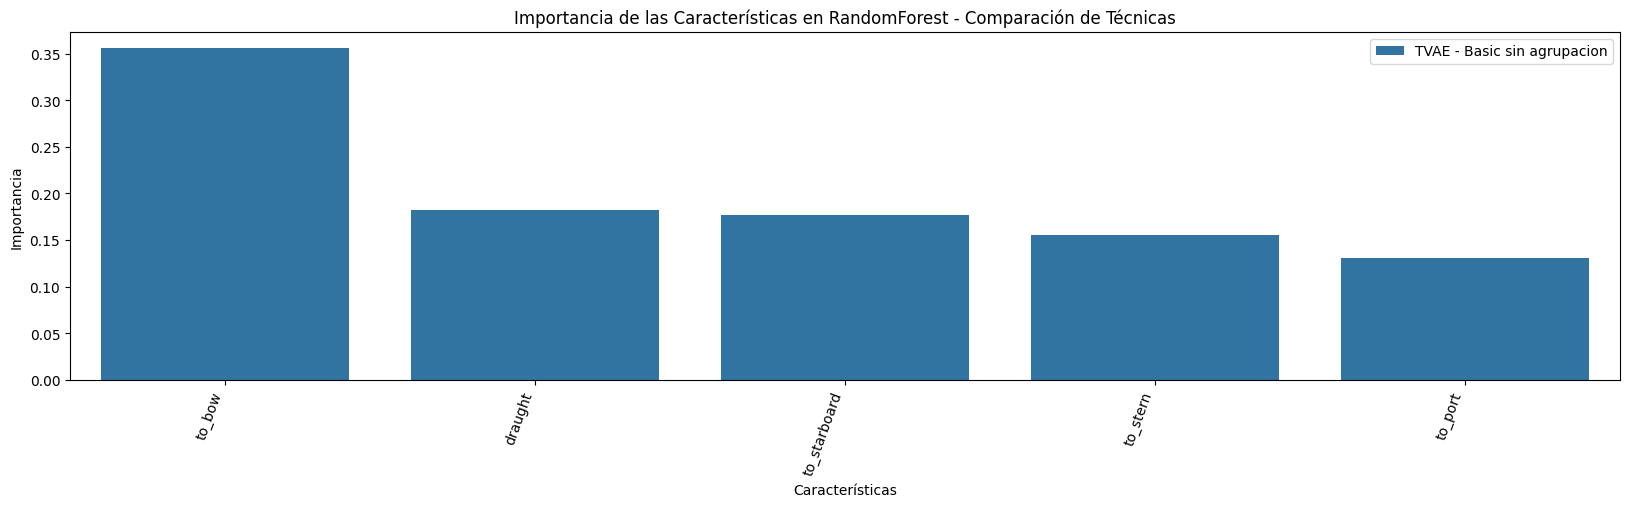

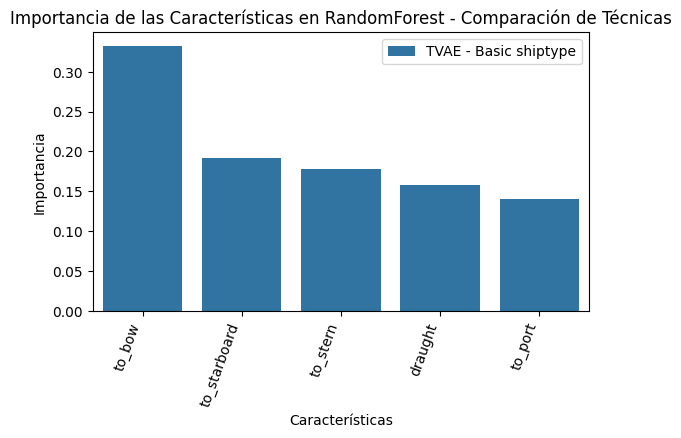

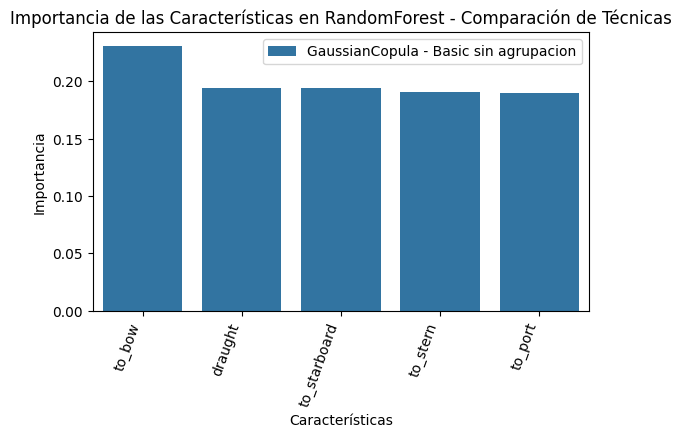

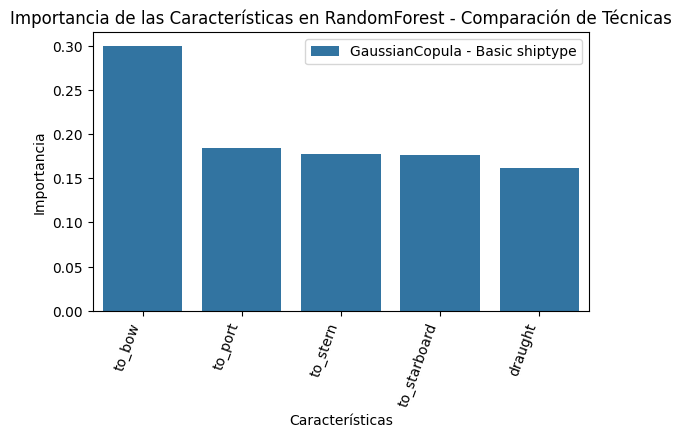

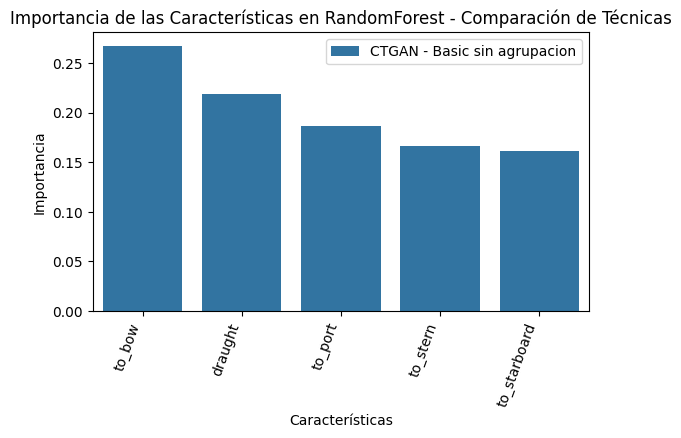

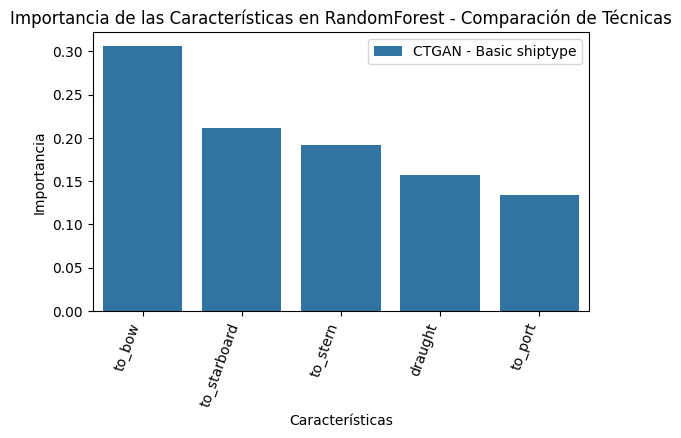

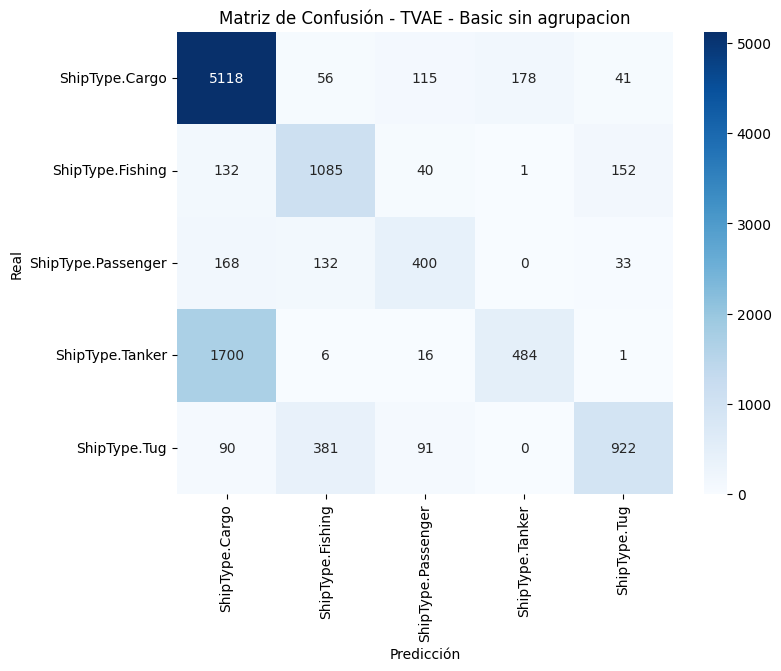

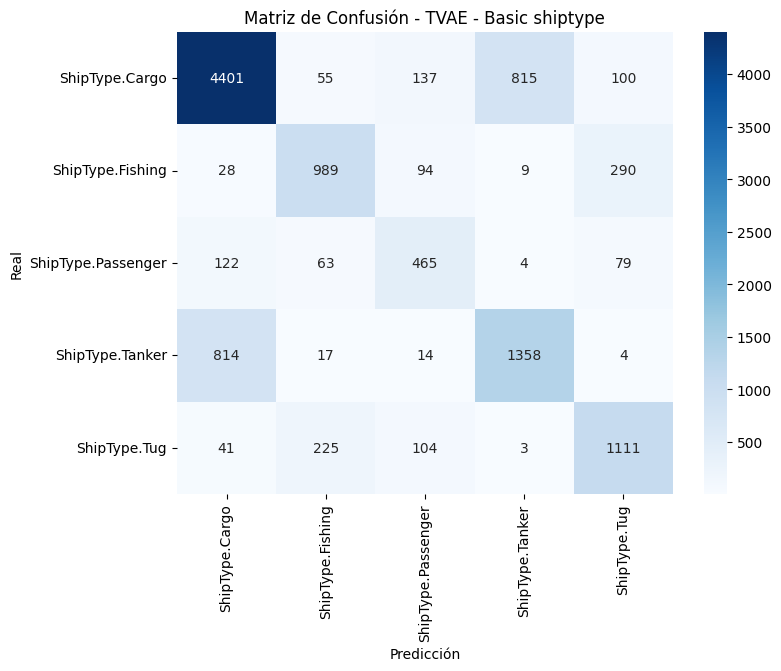

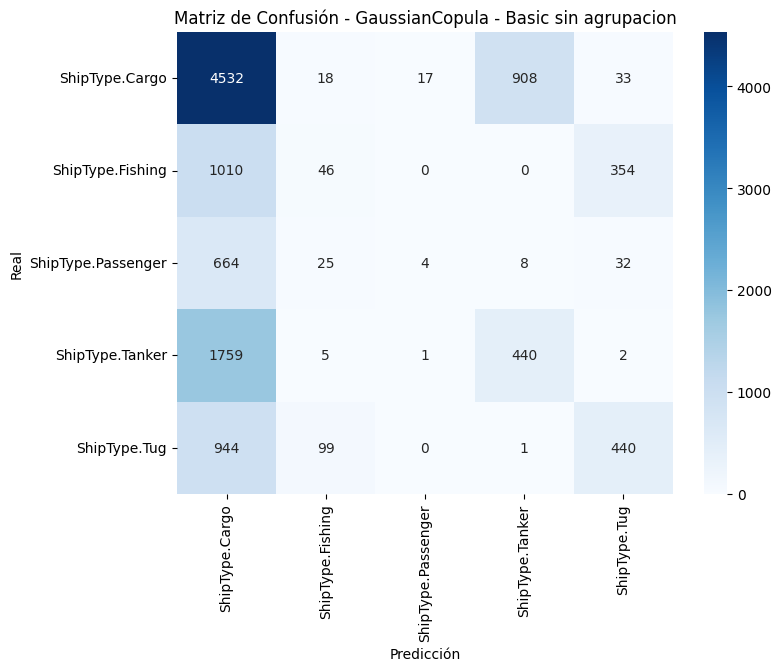

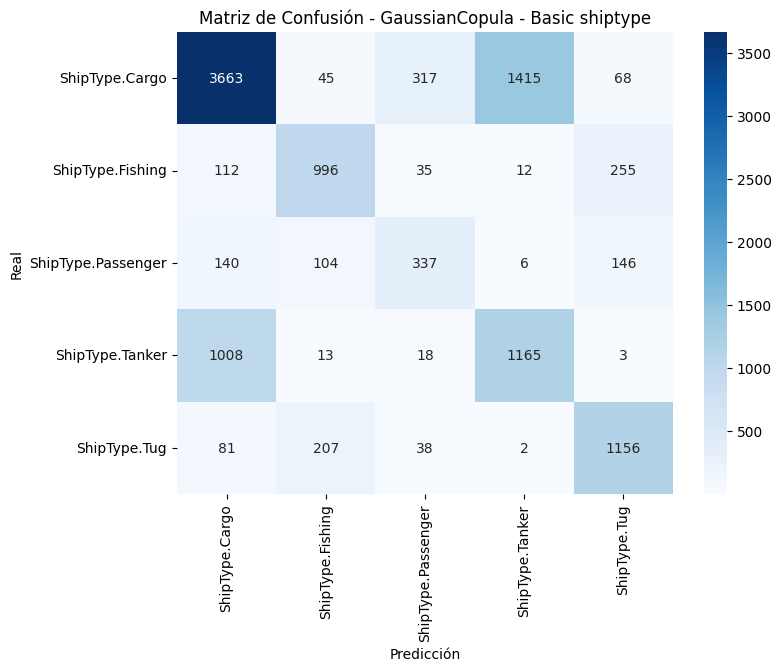

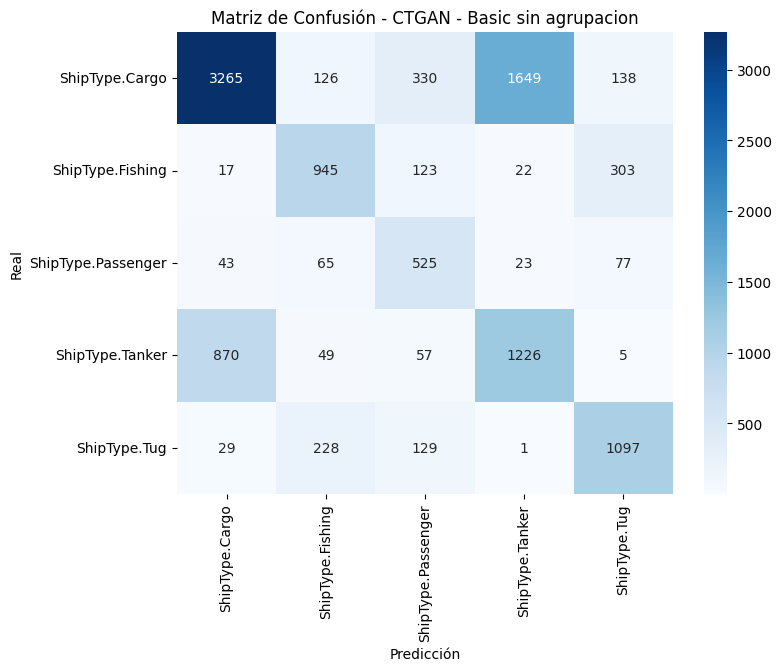

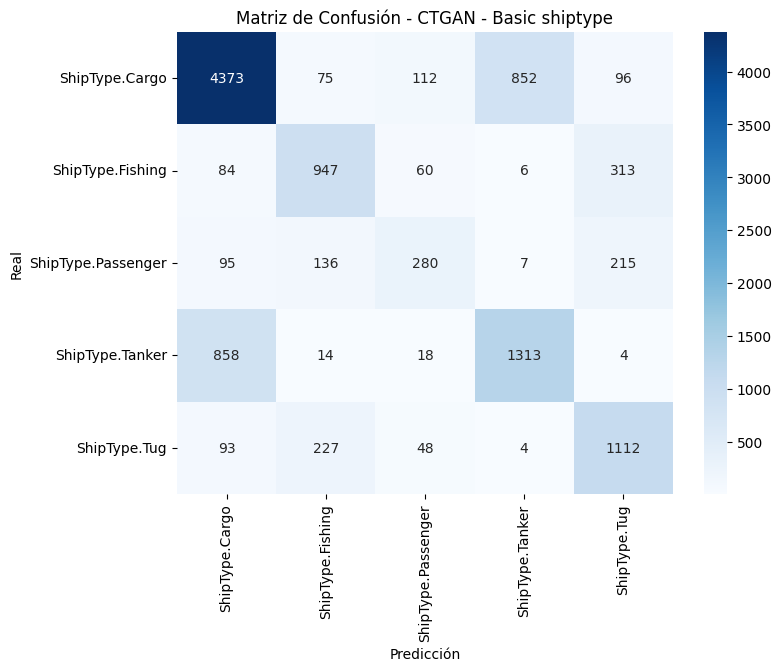

In [34]:
# Cargar los datos reales
real_data = pd.read_csv("final_static_data_basic.csv").drop(columns=["MMSI"], errors="ignore")

# Reemplazar valores infinitos por NaN y luego eliminarlos
real_data.replace([np.inf, -np.inf], np.nan, inplace=True)
real_data.dropna(inplace=True)

# Datasets sintéticos por técnica
techniques = ["TVAE", "GaussianCopula", "CTGAN"]
dataset_variants = [
    "Basic sin agrupacion", "Basic shiptype"
]

synthetic_data_dict = {}
for tech in techniques:
    synthetic_data_dict[tech] = {
        "Basic sin agrupacion": pd.read_csv(f"sinteticos_estaticos_{tech}_sin_distincion.csv").drop(columns=["MMSI"], errors="ignore").replace([np.inf, -np.inf], np.nan).dropna(),
        "Basic shiptype": pd.read_csv(f"synthetic_static_basic_{tech}.csv").drop(columns=["MMSI"], errors="ignore").replace([np.inf, -np.inf], np.nan).dropna(),
        
    }

# Separar datos reales en train y test
df_train, df_test = train_test_split(real_data, random_state=43)
x_test = df_test.drop(columns=['shiptype'])
y_test = df_test['shiptype']

# Binarizar etiquetas para calcular AUC-ROC
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Almacenar resultados
results = []
feature_importances = {}
conf_matrices = {}

for tech, datasets in synthetic_data_dict.items():
    for name, syn_data in datasets.items():
        print(f"Evaluando: {tech} - {name}")
        
        # Separar características y etiquetas en los datos sintéticos
        x_train = syn_data.drop(columns=['shiptype'])
        y_train = syn_data['shiptype']

         # Asegurar que las características coincidan con x_test
        x_train, x_test = x_train.align(x_test, join='inner', axis=1)
        
        # Crear modelo con pipeline
        pipe = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
        
        model = pipe.fit(x_train, y_train)
        y_pred = model.predict(x_test)

         # Calcular matriz de confusión
        conf_matrices[f"{tech} - {name}"] = confusion_matrix(y_test, y_pred)

        # Verificar si el clasificador soporta predict_proba
        if hasattr(model.named_steps['classifier'], "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)
            # Calcular AUC-ROC
            try:
                if len(classes) > 2:
                    auc_roc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
                else:
                    auc_roc = roc_auc_score(y_test_bin.ravel(), y_pred_proba[:, 1])
            except ValueError:
                print(f"No se pudo calcular AUC-ROC para {tech} - {name}")
                auc_roc = np.nan
        else:
            auc_roc = np.nan
        
        # Obtener métricas
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        accuracy = report['accuracy']
        f1 = report['weighted avg']['f1-score']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        
        results.append({
            "Técnica": tech,
            "Dataset": name,
            "Accuracy": accuracy,
            "F1-score": f1,
            "Precision": precision,
            "Recall": recall,
            "AUC-ROC": auc_roc,
        })
        
        # Obtener importancia de características
        forest = model.named_steps['classifier']
        importances = forest.feature_importances_
        feature_importances[f"{tech} - {name}"] = pd.Series(importances, index=x_train.columns).sort_values(ascending=False)

# Mostrar resultados en tabla
results_df = pd.DataFrame(results)
print(results_df)

# Graficar importancia de características para cada dataset sintético
plt.figure(figsize=(20, 6))
for key, fi in feature_importances.items():
    fi = fi.reset_index()
    fi.columns = ['att', 'importance']
    sns.barplot(data=fi, x='att', y='importance', label=key)
    plt.xticks(rotation=70, ha='right')
    plt.xlabel("Características")
    plt.ylabel("Importancia")
    plt.title("Importancia de las Características en RandomForest - Comparación de Técnicas")
    plt.legend()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

# Graficar matrices de confusión
for key, cm in conf_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {key}")
    plt.show()
